**Classifying diseases based on the augemented gut micobiota (GM) data**

In this notebook file, we will demonstrate how genus-level data can be used to classify diseases using machine learning algorithms. Here, we will be using four machine learning (ML) algorithms, including random forest (RF), support vector machine (SVM), artificial neural networks (ANN), and convolutional neural networks (CNN). Furthermore, we are looking into two different problems:

**1) classifying 5 conditions Crohn's disease (CD), ulcerative colitis (UC), Parkinson's disease (PD), human immuno deficiency virus (HIV), healthy control (HC):** We want to see whether it is possible to distinguish between diseases such as UC, which is mostly present in the gastrointestinal tract, and other diseases, such as PD, which mostly harbors the brain. All the mentioned diseases have been reported to induce conformational changes in GM.

**2) Classifying healthy vs non-healthy subjects:**  We want to see how well ML algorithms can distinguish between NH and HC.




In [26]:
#import all the required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
import os as os
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
import mpl_toolkits.mplot3d.axes3d as p3
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_swiss_roll
import time as time
from sklearn.neighbors import kneighbors_graph
from sklearn import mixture
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
from sklearn.utils import shuffle
import random
from matplotlib.lines import Line2D
cmap = plt.cm.coolwarm
from sklearn.model_selection import train_test_split
import matplotlib
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

In [27]:
####specify the output and input directories #########
Results_dir='/content/drive/MyDrive/food_science_disease_prediction/For_GitHub/Results_GitHub'##specify where you want all the results to be saved
data_baseline_added_HIV = pd.read_csv('/content/drive/MyDrive/food_science_disease_prediction/For_GitHub/Data_GitHub/Data_baseline_augmented.csv') #Reading the baseline augmented data

In [28]:
#print data head
data_baseline_added_HIV.head()

,subject,condition,Treatment,time,Acetate,Propionate,Butyrate,Gas,Abiotrophia,Acidaminococcus,...,Sutterella,Sutterellaceae,Syntrophomonas,Turicibacter,Varibaculum,Veillonella,Veillonellaceae,Victivallis,the_rest,condition_codes
0,C01,CD,Feces,0,2.78,3.07,1.35,1.0,0.0,0.001273,...,0.000116,0.0,0.0,0.000463,0.0,0.00000,0.000463,0.0,0.223045,0
1,C01,CD,Feces,0,2.6,2.93,1.32,1.0,0.0,0.001249,...,0.000514,0.0,0.0,0.000367,0.0,0.00000,0.000661,0.0,0.241240,0
2,C01,CD,Feces,0,10.66579913,3.82690772,2.564750073,9.5,0.0,0.000728,...,0.000040,0.0,0.0,0.000445,0.0,0.00002,0.000991,0.0,0.256292,0
3,C01,CD,Feces,0,12.03335332,3.858210662,0.040255341,9.5,0.0,0.001585,...,0.000207,0.0,0.0,0.000413,0.0,0.00000,0.001171,0.0,0.224695,0
4,C02,CD,Feces,0,1.04,0.45,0.45,1.0,0.0,0.000000,...,0.000133,0.0,0.0,0.000133,0.0,0.00000,0.000000,0.0,0.171628,0


In [24]:
###define convolutional functions for CNN
def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


###The block used for CNN
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes=1, planes=3, num_classes_condition=5, data_len=100, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm1d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.data_len = data_len
        self.num_classes_condition = num_classes_condition
        self.fc_2 = nn.Linear(self.data_len * planes, self.data_len)
        self.fcc_2 = nn.Linear(self.data_len, self.num_classes_condition)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        ######
        #identity=out
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out = self.relu(out)
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out += identity
        #out = self.relu(out)
        ###########
        ######
        #identity=out
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out = self.relu(out)
        #out = self.conv2(out)
        #out = self.bn2(out)
        #out += identity
        #out = self.relu(out)

        out_2 = out.view(out.size(0), -1)


        out_2 = self.fc_2(out_2)
        out_2 = self.relu(out_2)
        out_2 = self.fcc_2(out_2)
        return out_2


class myDataset(Dataset):
  def __init__(self,X,Y,transform=None):
    self.x = X
    self.y = Y
    self.transform = transform

  def __len__(self):
    return len(self.y)

  def __getitem__(self,index):
    input = self.x[index].reshape(1,-1).astype(np.float32)
    # label = self.class2idx[self.y[index]]
    labels_condition = self.y[index][0]
    return {'input':torch.from_numpy(input), 'labels_condition':torch.as_tensor(labels_condition, dtype=torch.torch.int64)}


### Define a class for saving the results to understand how accuracies vary for different sizes as well as

## available methods are RF, SVM, ANN, CNN
## input_data can be either the whole data or data without fiber treatment
## number_of_smaples you want to have
class classifier:
      def __init__(self,output_dir,input_data,input_data_type, method,classification_problem,start_index,end_index, ssave='True'):
          self.data=input_data.copy()
          self.method=method
          self.save=ssave
          self.output_dir=output_dir
          self.input_data_type=input_data_type
          self.classification_problem=classification_problem
          self.start_index=start_index
          self.end_index=end_index
      ###Define a function for training and predictions with methods such as RF, SVM, and ANN using Sklearn
      def train_and_predict_Sklearn(self):
          accuracies=dict()
          if self.method=='RF':
             model=RandomForestClassifier(max_depth= 20, max_features =2, min_samples_split= 2, n_estimators= 500, random_state=10)
          elif self.method=='SVM':
             model=SVC(C=500,random_state=10,decision_function_shape='ovr',probability=True)
          elif self.method=='ANN':
             model = MLPClassifier(activation= 'tanh', alpha= 0.05, hidden_layer_sizes= (60, 60, 60, 60), learning_rate= 'constant', solver= 'adam',random_state=10)
          elif self.method=='GB':
             model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
          data=self.data.copy()
          end_index=self.end_index
          start_index=self.start_index
          #end_index=data.columns.get_loc("unassigned unassigned")+1
          #start_index=data.columns.get_loc("Abiotrophia")

          ###define to dictionatoes to obtain labels from conditions and vice versa
          condition_to_labels={}
          labels_to_condition={}
          for i in range(len(data)):
              if not data['condition'].iloc[i] in condition_to_labels:
                 condition_to_labels[data['condition'].iloc[i]]=data['condition_codes'].iloc[i]
          for i in range(len(data)):
              if not data['condition_codes'].iloc[i] in labels_to_condition:
                 labels_to_condition[data['condition_codes'].iloc[i]]=data['condition'].iloc[i]
          ##sort data alphabetically
          condition_to_labels = dict(sorted(condition_to_labels.items(), key=lambda item: item[1]))
          X=data.iloc[:,start_index:end_index].values
          ####choos 'condition_codes' as the column of interest for the output prediction
          columns_of_interest=['condition_codes']
          Y=data[columns_of_interest].values
          ###use 5-fold cross validation
          cv=KFold(n_splits=5,shuffle=True,random_state=42)
          scores=[]
          scoring = ['precision_macro', 'recall_macro','f1_macro','precision_micro', 'recall_micro','f1_micro','accuray']
          prediction_mat=dict()
          for ii, (train, test) in enumerate(cv.split(X, Y)):
              X_train=X[train]
              Y_train=Y[train]
              X_test=X[test]
              Y_test=Y[test]
              true_labels_condition = Y_test
              model.fit(X_train,Y_train)
              Y_pred=model.predict(X_test)
              predictions_labels_conditions=Y_pred
              predictions_labels_conditions=np.array(predictions_labels_conditions).reshape(-1,1)
              Y_scores=model.predict_proba(X_test)
              predictions_labels_conditions=np.array(predictions_labels_conditions).reshape(-1,1)
              prediction_mat['y_test_fold_{}'.format(ii)] = Y_test.reshape(-1)
              prediction_mat['y_pred_fold_{}'.format(ii)] = predictions_labels_conditions.reshape(-1)
              for nj in range(Y_scores.shape[1]):
                  prediction_mat['y_score_class_{}_fold_{}'.format(nj,ii)] = (Y_scores[:,nj]).reshape(-1)

              precision_macro=precision_score(Y_test, predictions_labels_conditions, average='macro')
              precision_micro=precision_score(Y_test, predictions_labels_conditions, average='micro')
              recall_macro=recall_score(Y_test, predictions_labels_conditions, average='macro')
              recall_micro=recall_score(Y_test, predictions_labels_conditions, average='micro')
              f1_micro=f1_score(Y_test, predictions_labels_conditions, average='micro')
              f1_macro=f1_score(Y_test, predictions_labels_conditions, average='macro')
              accurcay=accuracy_score(Y_test, predictions_labels_conditions)
              scores.append([precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,accurcay])
          prediction_mat=pd.DataFrame({ key:pd.Series(value) for key, value in prediction_mat.items() })
          prediction_mat.dropna(inplace=True)
          scores=np.array(scores)
          scores_dict=dict()
          i=0
          pred_labels_cond = np.array(predictions_labels_conditions)
          for scor in scoring:
              scores_dict[scor+'_mean']=[np.round(scores.mean(axis=0)[i], 3)]
              scores_dict[scor+'_std']=[np.round(scores.std(axis=0)[i], 3)]
              i=i+1
          score_DF = pd.DataFrame(scores_dict)
          if self.save:
             out_dir=self.output_dir+'/predictions'
             if not os.path.exists(out_dir):
                os.mkdir(out_dir)
             accuracies_Dic={}
             prediction_mat.to_csv(out_dir+'/'+'predictions_vs_actual_{}_{}_{}.csv'.format(self.method,self.input_data_type,self.classification_problem),index=False)
             score_DF.to_csv(out_dir+'/'+'predictions_scores_{}_{}_{}.csv'.format(self.method,self.input_data_type,self.classification_problem),index=False)
          return prediction_mat,pred_labels_cond,true_labels_condition,condition_to_labels,score_DF
      ###define a function for training and predictions using CNN with PyTroch
      def train_and_predict_Torch(self):
          self.method='CNN'
          data=self.data.copy()
          end_index=self.end_index
          start_index=self.start_index
          #end_index=data.columns.get_loc("unassigned unassigned")+1
          #start_index=data.columns.get_loc("Abiotrophia")
          condition_to_labels={}
          labels_to_condition={}
          for i in range(len(data)):
              if not data['condition'].iloc[i] in condition_to_labels:
                 condition_to_labels[data['condition'].iloc[i]]=data['condition_codes'].iloc[i]
          for i in range(len(data)):
              if not data['condition_codes'].iloc[i] in labels_to_condition:
                 labels_to_condition[data['condition_codes'].iloc[i]]=data['condition'].iloc[i]
          condition_to_labels = dict(sorted(condition_to_labels.items(), key=lambda item: item[1]))
          num_classes_condition=len(condition_to_labels)
          X=data.iloc[:,start_index:end_index].values
          columns_of_interest=['condition_codes']
          Y=data[columns_of_interest].values
          ###use 5-fold cross validation
          cv=KFold(n_splits=5,shuffle=True,random_state=42)
          prediction_mat=dict()
          scores=[]
          for iii, (train, test) in enumerate(cv.split(X, Y)):
              X_train=X[train]
              Y_train=Y[train]
              X_test=X[test]
              Y_test=Y[test]
              train_dataset = myDataset(X_train,Y_train)
              test_dataset = myDataset(X_test,Y_test)
              train_data_loader = DataLoader(dataset = train_dataset,batch_size =20,shuffle =True,num_workers=2)
              test_data_loader = DataLoader(dataset = test_dataset,batch_size =1000,shuffle =False,num_workers=2)
              seed = 0
              random.seed(seed)
              torch.manual_seed(seed)
              device = torch.device ("cuda:0" if torch.cuda.is_available ()
                                  else "cpu")
              net = BasicBlock(num_classes_condition=num_classes_condition, data_len=X.shape[1])

              net = net.to(device)
              criterion = nn.CrossEntropyLoss()
              optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=0.1)
              #play with the poch size, for more accurate results, set it to 500, but it will take a couple of hours
              epochs=500
              loss_tot_condition=[]
              loss_condition_train=[]
              loss_condition_test=[]
              eepoch=[]
              for epoch in range(epochs):
                  my_loss_condition = 0.0
                  eepoch.append(epoch+1)
                  for k, data in enumerate(train_data_loader):
                      inputs,  labels_condition = data["input"], data["labels_condition"]
                      inputs = inputs.to(device)
                      labels_condition = labels_condition.to(device)
                      optimizer.zero_grad()
                      outputs = net(inputs)
                      outputs_condition_label = outputs
                      loss_condition = criterion(outputs_condition_label, labels_condition)
                      loss_condition.backward(retain_graph=True)
                      optimizer.step()
                      my_loss_condition += loss_condition.item()
              for k, data in enumerate(test_data_loader):
                  inputs,  labels_condition = data["input"], data["labels_condition"]
                  inputs = inputs.to(device)
                  labels_condition = labels_condition.to(device)
                  #optimizer.zero_grad()
                  outputs = net(inputs)
                  Y_scores = torch.sigmoid(outputs)
                  outputs_condition_label = outputs
              predictions_labels_conditions = []
              for j in range(outputs_condition_label.shape[0]):
                  predictions_labels_conditions.append(torch.argmax(outputs_condition_label[j]).cpu().numpy())
              precision_macro=precision_score(Y_test, predictions_labels_conditions, average='macro')
              precision_micro=precision_score(Y_test, predictions_labels_conditions, average='micro')
              recall_macro=recall_score(Y_test, predictions_labels_conditions, average='macro')
              recall_micro=recall_score(Y_test, predictions_labels_conditions, average='micro')
              f1_micro=f1_score(Y_test, predictions_labels_conditions, average='micro')
              f1_macro=f1_score(Y_test, predictions_labels_conditions, average='macro')
              accurcay=accuracy_score(Y_test, predictions_labels_conditions)
              scores.append([precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro,accurcay])
              predictions_labels_conditions=np.array(predictions_labels_conditions).reshape(-1,1)
              prediction_mat['y_test_fold_{}'.format(iii)] = Y_test.reshape(-1)
              prediction_mat['y_pred_fold_{}'.format(iii)] = predictions_labels_conditions.reshape(-1)
              for nj in range(Y_scores.shape[1]):
                  prediction_mat['y_score_class_{}_fold_{}'.format(nj,iii)] = (Y_scores[:,nj]).cpu().detach().numpy().reshape(-1)
              scoring = ['precision_macro', 'recall_macro','f1_macro','precision_micro', 'recall_micro','f1_micro','accuray']


          pred_labels_cond = np.array(predictions_labels_conditions)
          Y_pred=pred_labels_cond
          true_labels_condition = labels_condition.cpu().numpy()
          scores=np.array(scores)
          prediction_mat=pd.DataFrame({ key:pd.Series(value) for key, value in prediction_mat.items() })
          prediction_mat.dropna(inplace=True)
          scores_dict=dict()
          ii=0
          for scor in scoring:
              scores_dict[scor+'_mean']=[np.round(scores.mean(axis=0)[ii], 3)]
              scores_dict[scor+'_std']=[np.round(scores.std(axis=0)[ii], 3)]
              ii=ii+1
          score_DF = pd.DataFrame(scores_dict)
          if self.save:
             out_dir=self.output_dir+'/predictions'
             if not os.path.exists(out_dir):
                os.mkdir(out_dir)
             prediction_mat.to_csv(out_dir+'/'+'predictions_vs_actual_{}_{}_{}.csv'.format(self.method,self.input_data_type,self.classification_problem),index=False)
             score_DF.to_csv(out_dir+'/'+'predictions_scores_{}_{}_{}.csv'.format(self.method,self.input_data_type,self.classification_problem),index=False)
          return prediction_mat,pred_labels_cond,true_labels_condition,condition_to_labels,score_DF

**1) classifying 5 conditions for the augemented baseline data**

We can demonstrate the classification metrics and plot confusion matrix for different ML methods and compare them

In [25]:
problem='5_conditions'
data_type='baseline_augmented'
data = data_baseline_added_HIV


###Creating an intance of the classifier class
end_index=data.columns.get_loc("Victivallis")+2
start_index=data.columns.get_loc("Abiotrophia")


instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)
instant_ANN=classifier(Results_dir,data,data_type,'ANN',problem,start_index,end_index,True)


###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()
outputs_ANN=instant_ANN.train_and_predict_Sklearn()



<ipython-input-24-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-24-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-24-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-24-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-24-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.908                0.047              0.906   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.044          0.895         0.053                 0.907   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.048              0.907             0.048          0.907   

   f1_micro_std  accuray_mean  accuray_std  
0         0.048         0.907        0.048  
[[ 4  0  0  0  2]
 [ 0  8  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0  8  0]
 [ 0  0  0  0  4]]
[0.66666667 0.         0.         0.         0.33333333]
[[ 4  0  0  0  2]
 [ 0  8  0  0  0]
 [ 0  0 10  0  0]
 [ 0  0  0  8  0]
 [ 0  0  0  0  4]]


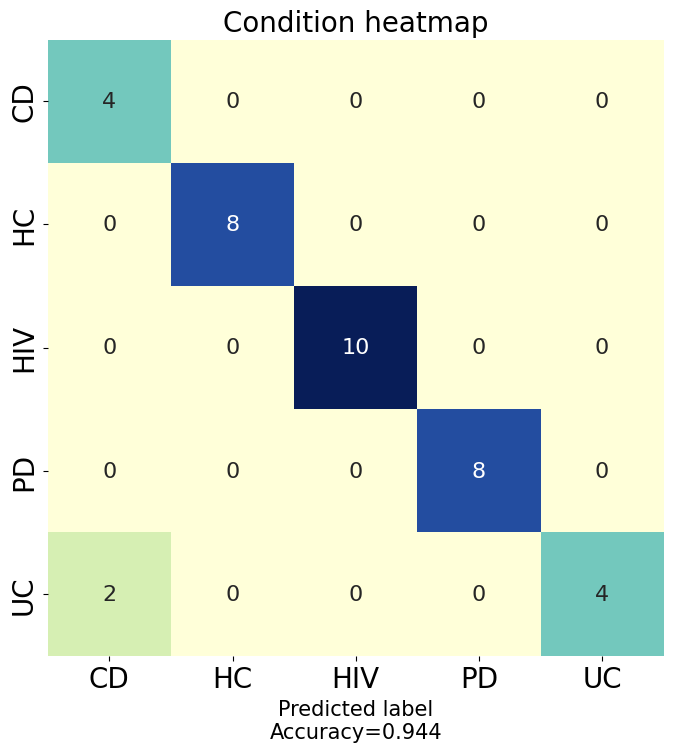

In [9]:
####Using ANN method
#output=outputs_ANN
#output=outputs_SVM
output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.926                0.046              0.933   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.033          0.923         0.041                 0.934   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.033              0.934             0.033          0.934   

   f1_micro_std  accuray_mean  accuray_std  
0         0.033         0.934        0.033  
[[4 0 0 0 2]
 [0 8 1 0 0]
 [0 0 9 0 0]
 [0 0 0 8 0]
 [0 0 0 0 4]]
[0.66666667 0.         0.         0.         0.33333333]
[[4 0 0 0 2]
 [0 8 1 0 0]
 [0 0 9 0 0]
 [0 0 0 8 0]
 [0 0 0 0 4]]


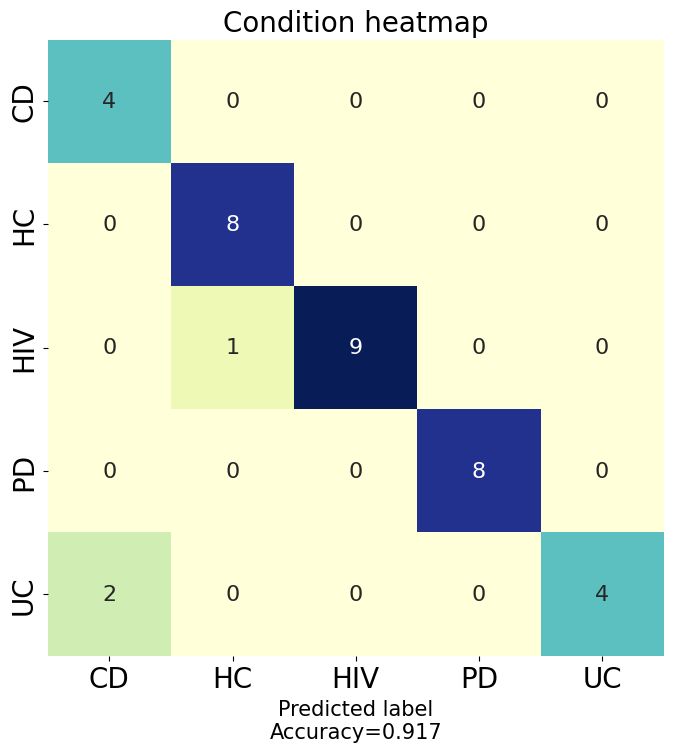

In [10]:
####Using GB method
#output=outputs_ANN
output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.901                0.044              0.899   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.034           0.89          0.04                 0.902   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.037              0.902             0.037          0.902   

   f1_micro_std  accuray_mean  accuray_std  
0         0.037         0.902        0.037  
[[4 0 0 0 2]
 [0 8 2 0 0]
 [0 0 8 0 0]
 [0 0 0 8 0]
 [0 0 0 0 4]]
[0.66666667 0.         0.         0.         0.33333333]
[[4 0 0 0 2]
 [0 8 2 0 0]
 [0 0 8 0 0]
 [0 0 0 8 0]
 [0 0 0 0 4]]


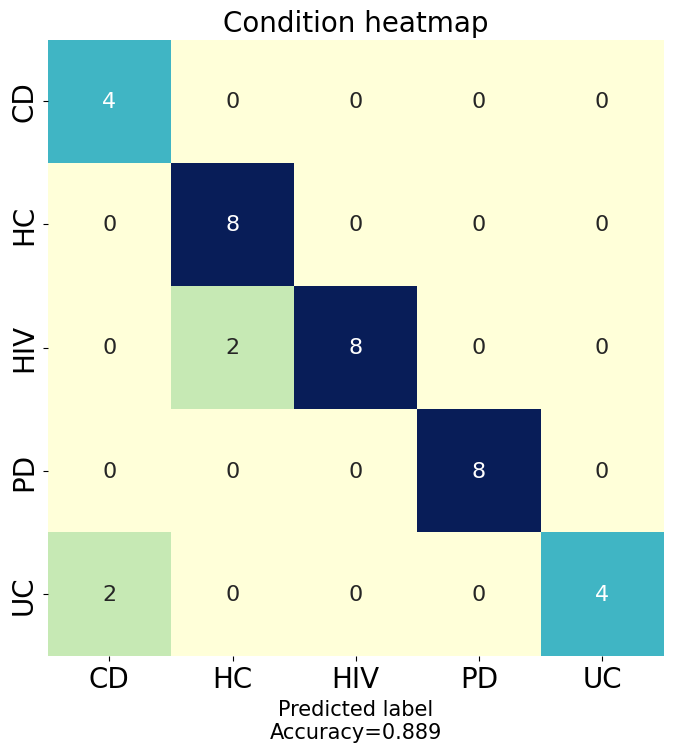

In [11]:
####Using SVM method
output=outputs_ANN
#output=outputs_SVM
#output=outputs_RF

metrics=output[4]
print(metrics.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)


from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


**2) Classifying healthy vs non-healthy subjects:**
We can demonstrate the classification metrics and plot confusion matrix for different ML methods and compare them as well as the ROC curves

In [12]:
data = data_baseline_added_HIV.iloc[:,:-1]
Healthy_control=data[data['condition']=='HC']
print('len_healthy_control',len(Healthy_control))
Non_healthy=data[data['condition']!='HC']
print('len_Non_healthy',len(Non_healthy))

data['condition_codes']=data['condition'].values

for i in range(len(data)):
    if data.iloc[i,1]!='HC':
       data.iloc[i,1]='NH'

for i in range(len(data)):
    if data.iloc[i,1]=='HC':
       data.iloc[i,-1]=0
    else:
       data.iloc[i,-1]=1


data['condition_codes']=data['condition_codes'].astype(int)



problem='HC_NH'
data_type='baseline_augmented'


###Creating an intance of the classifier class
end_index=data.columns.get_loc("Victivallis")+2
start_index=data.columns.get_loc("Abiotrophia")


instant_RF=classifier(Results_dir,data,data_type,'RF',problem,start_index,end_index,True)
instant_SVM=classifier(Results_dir,data,data_type,'SVM',problem,start_index,end_index,True)
instant_ANN=classifier(Results_dir,data,data_type,'ANN',problem,start_index,end_index,True)
###Training and prediction
outputs_RF=instant_RF.train_and_predict_Sklearn()
outputs_SVM=instant_SVM.train_and_predict_Sklearn()
outputs_ANN=instant_ANN.train_and_predict_Sklearn()


len_healthy_control 45
len_Non_healthy 138


<ipython-input-6-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-6-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-6-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-6-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train,Y_train)
<ipython-input-6-42305a8b61c6>:156: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Pl

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.963                 0.02              0.884   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.049          0.913         0.043                  0.94   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.032               0.94             0.032           0.94   

   f1_micro_std  accuray_mean  accuray_std  
0         0.032          0.94        0.032  
[[ 7  0]
 [ 1 28]]
[1. 0.]
[[ 7  0]
 [ 1 28]]
[0.         0.03846154 0.26923077 0.42307692 0.80769231 0.88461538
 0.88461538 0.92307692 1.         1.        ]
[0.  0.  0.  0.  0.  0.  0.1 0.1 0.1 1. ]
[0.         0.03448276 0.20689655 0.27586207 0.31034483 0.37931034
 0.4137931  0.48275862 0.68965517 0.82758621 1.         1.        ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0.         0.03703704 0.14814815 0.22222222 0.25925926 0.33333333
 0.37037037 0.44444444 0.481

Text(0, 0.5, 'True Positive Rate')

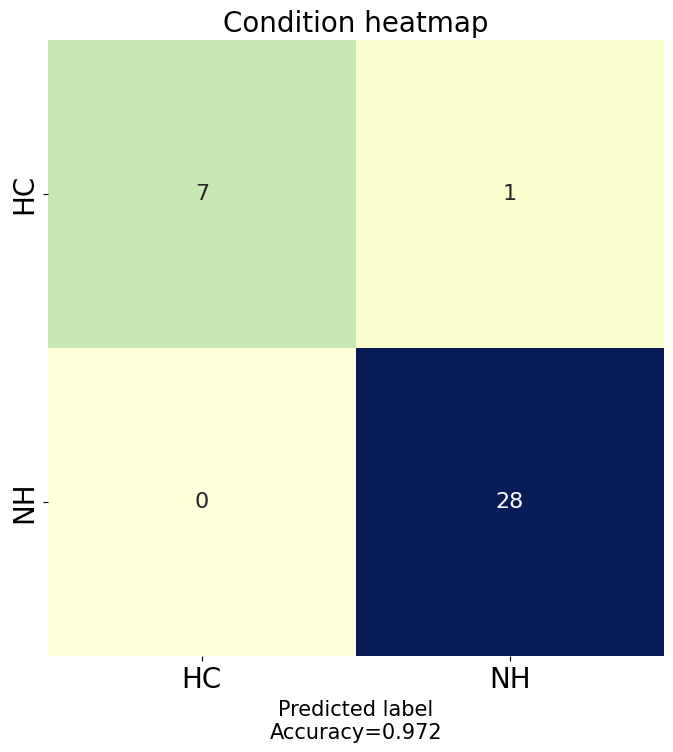

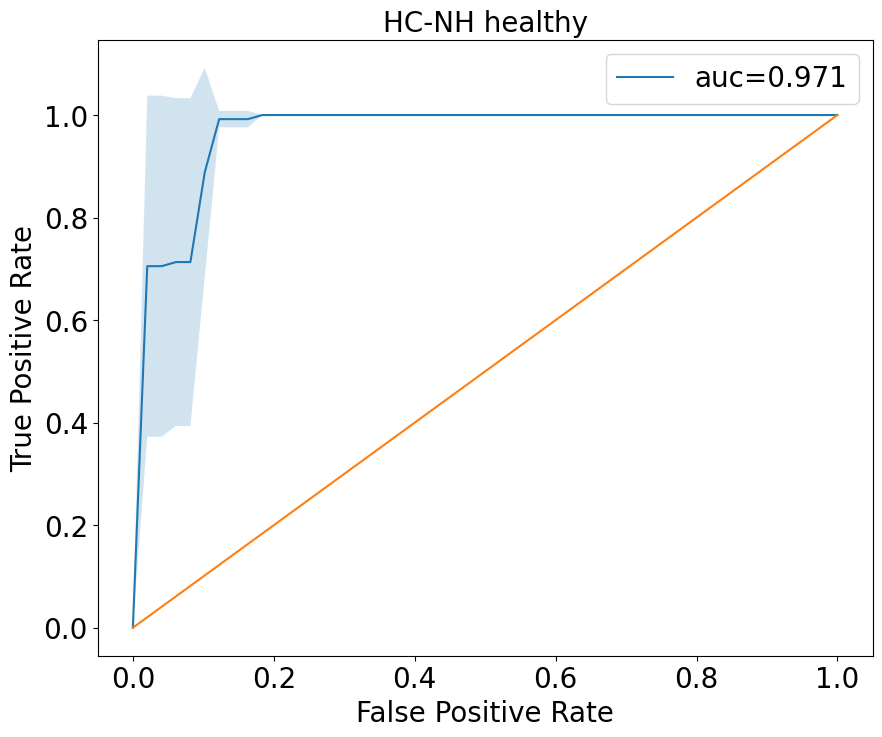

In [13]:
####Using SVM method
#output=outputs_SVM
#output=outputs_ANN
output=outputs_RF

metricss=output[4]
print(metricss.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)

from sklearn import metrics

from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))




from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


fprs=[]
tprs=[]
roc_aucs=[]

fprs_len=[]

for n in range(len(columns_of_interest)):
    Y_score=prediction_mat[columns_of_interest[n]].values
    Y_test=prediction_mat[columns_of_interest_y[n]].values
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_score)
    fprs_len.append(len(fpr))
    fprs.append(fpr)

fprs_len=np.array(fprs_len)
mean_fpr=fprs[np.argmax(fprs_len)]

mean_fpr = np.linspace(0, 1, 50)

for n in range(len(columns_of_interest)):
    Y_score=prediction_mat[columns_of_interest[n]].values
    Y_test=prediction_mat[columns_of_interest_y[n]].values
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_score)
    print(tpr)
    print(fpr)
    roc_auc=metrics.auc(fpr, tpr)
    tp_d = interp1d(fpr, tpr, kind='nearest')
    tpr =  tp_d(mean_fpr)
    tprs.append(tpr)
    roc_aucs.append(roc_auc)

fpr=mean_fpr.copy()
tpr=np.mean(np.array(tprs),axis=0)
tpr_lower=np.mean(np.array(tprs),axis=0)-np.std(np.array(tprs),axis=0)
tpr_upper=np.mean(np.array(tprs),axis=0)+np.std(np.array(tprs),axis=0)
roc_aucs=np.array(roc_aucs)


plt.figure(figsize=(10, 8))
plt.plot(fpr,tpr,label='auc={:.3f}'.format(roc_aucs.mean()))
plt.fill_between(fpr,tpr_lower,tpr_upper,alpha=0.2)
y_d=np.linspace(0,1,10)
plt.plot(y_d,y_d)
plt.legend(fontsize=20)
plt.title('HC-NH healthy',fontsize=20)
plt.xlabel("False Positive Rate",fontsize=20)
plt.ylabel("True Positive Rate",fontsize=20)

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                 0.952                0.051              0.966   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.034          0.957         0.042                 0.967   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.032              0.967             0.032          0.967   

   f1_micro_std  accuray_mean  accuray_std  
0         0.032         0.967        0.032  
[[ 8  2]
 [ 0 26]]
[0.8 0.2]
[[ 8  2]
 [ 0 26]]
[0.         0.03846154 1.         1.        ]
[0. 0. 0. 1.]
[0.         0.03448276 1.         1.        ]
[0. 0. 0. 1.]
[0.         0.03703704 0.48148148 0.48148148 1.         1.        ]
[0.         0.         0.         0.11111111 0.11111111 1.        ]
[0. 0. 1. 1.]
[0.         0.09090909 0.09090909 1.        ]
[0.         0.03571429 1.         1.        ]
[0. 0. 0. 1.]


Text(0, 0.5, 'True Positive Rate')

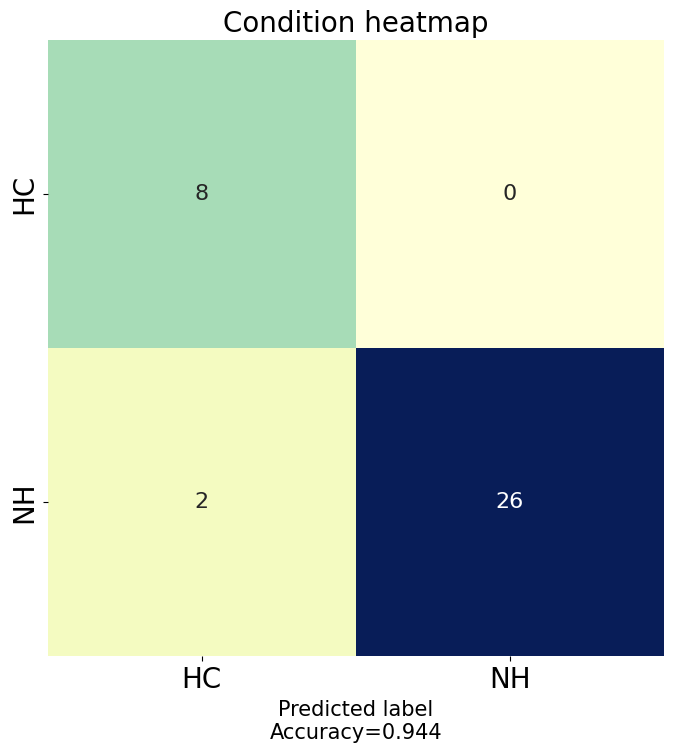

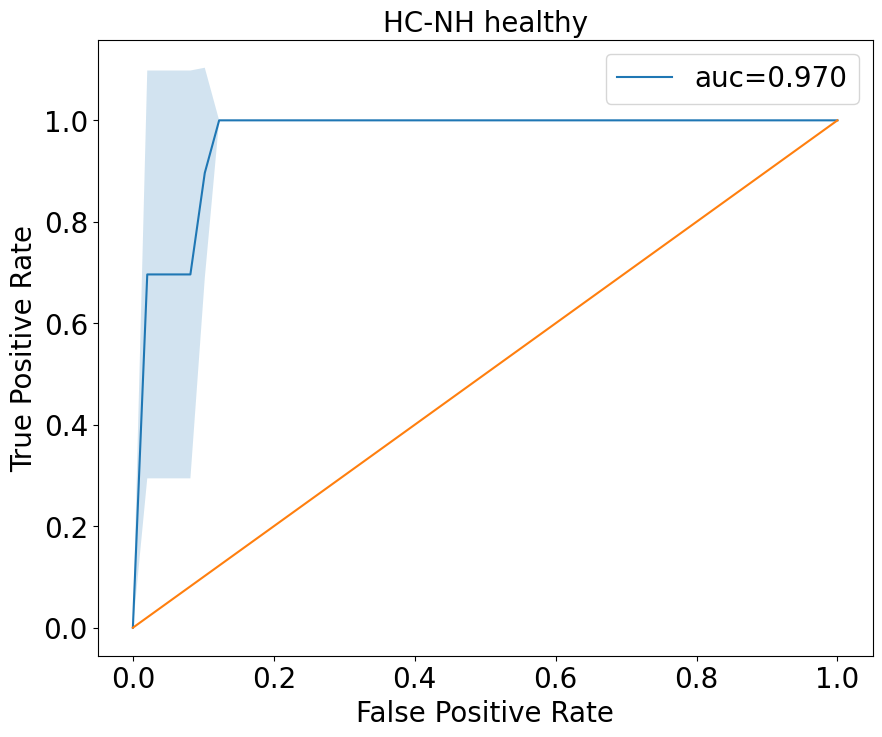

In [14]:
####Using SVM method
output=outputs_SVM
#output=outputs_ANN
#output=outputs_RF

metricss=output[4]
print(metricss.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)

from sklearn import metrics

from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))




from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


fprs=[]
tprs=[]
roc_aucs=[]

fprs_len=[]

for n in range(len(columns_of_interest)):
    Y_score=prediction_mat[columns_of_interest[n]].values
    Y_test=prediction_mat[columns_of_interest_y[n]].values
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_score)
    fprs_len.append(len(fpr))
    fprs.append(fpr)

fprs_len=np.array(fprs_len)
mean_fpr=fprs[np.argmax(fprs_len)]

mean_fpr = np.linspace(0, 1, 50)

for n in range(len(columns_of_interest)):
    Y_score=prediction_mat[columns_of_interest[n]].values
    Y_test=prediction_mat[columns_of_interest_y[n]].values
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_score)
    print(tpr)
    print(fpr)
    roc_auc=metrics.auc(fpr, tpr)
    tp_d = interp1d(fpr, tpr, kind='nearest')
    tpr =  tp_d(mean_fpr)
    tprs.append(tpr)
    roc_aucs.append(roc_auc)

fpr=mean_fpr.copy()
tpr=np.mean(np.array(tprs),axis=0)
tpr_lower=np.mean(np.array(tprs),axis=0)-np.std(np.array(tprs),axis=0)
tpr_upper=np.mean(np.array(tprs),axis=0)+np.std(np.array(tprs),axis=0)
roc_aucs=np.array(roc_aucs)


plt.figure(figsize=(10, 8))
plt.plot(fpr,tpr,label='auc={:.3f}'.format(roc_aucs.mean()))
plt.fill_between(fpr,tpr_lower,tpr_upper,alpha=0.2)
y_d=np.linspace(0,1,10)
plt.plot(y_d,y_d)
plt.legend(fontsize=20)
plt.title('HC-NH healthy',fontsize=20)
plt.xlabel("False Positive Rate",fontsize=20)
plt.ylabel("True Positive Rate",fontsize=20)

   precision_macro_mean  precision_macro_std  recall_macro_mean  \
0                  0.95                0.048              0.962   

   recall_macro_std  f1_macro_mean  f1_macro_std  precision_micro_mean  \
0             0.021          0.952         0.033                 0.962   

   precision_micro_std  recall_micro_mean  recall_micro_std  f1_micro_mean  \
0                0.028              0.962             0.028          0.962   

   f1_micro_std  accuray_mean  accuray_std  
0         0.028         0.962        0.028  
[[ 8  2]
 [ 0 26]]
[0.8 0.2]
[[ 8  2]
 [ 0 26]]
[0.         0.03846154 0.92307692 0.92307692 0.96153846 0.96153846
 1.         1.        ]
[0.  0.  0.  0.2 0.2 0.6 0.6 1. ]
[0.         0.03448276 1.         1.        ]
[0. 0. 0. 1.]
[0.         0.03703704 0.25925926 0.25925926 1.         1.        ]
[0.         0.         0.         0.11111111 0.11111111 1.        ]
[0.   0.04 0.04 1.   1.  ]
[0.         0.         0.09090909 0.09090909 1.        ]
[0.         0.03

Text(0, 0.5, 'True Positive Rate')

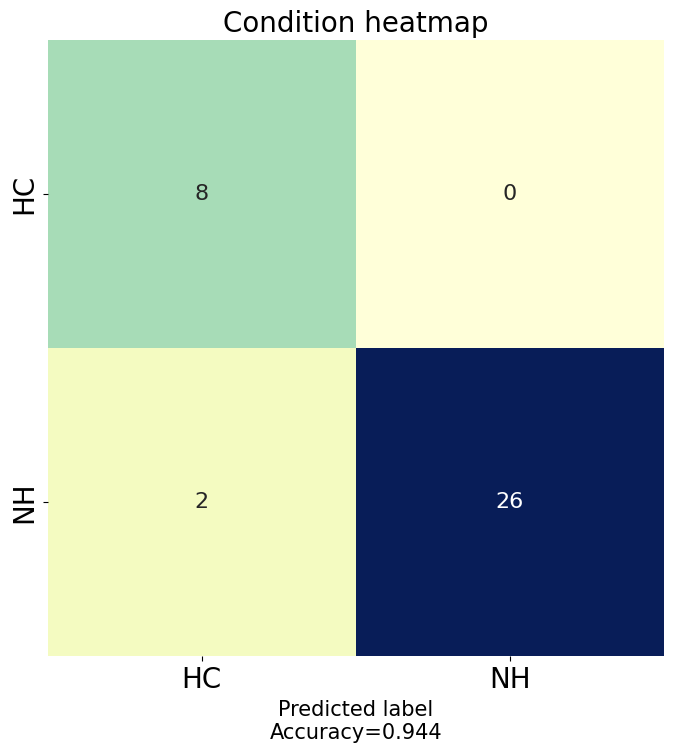

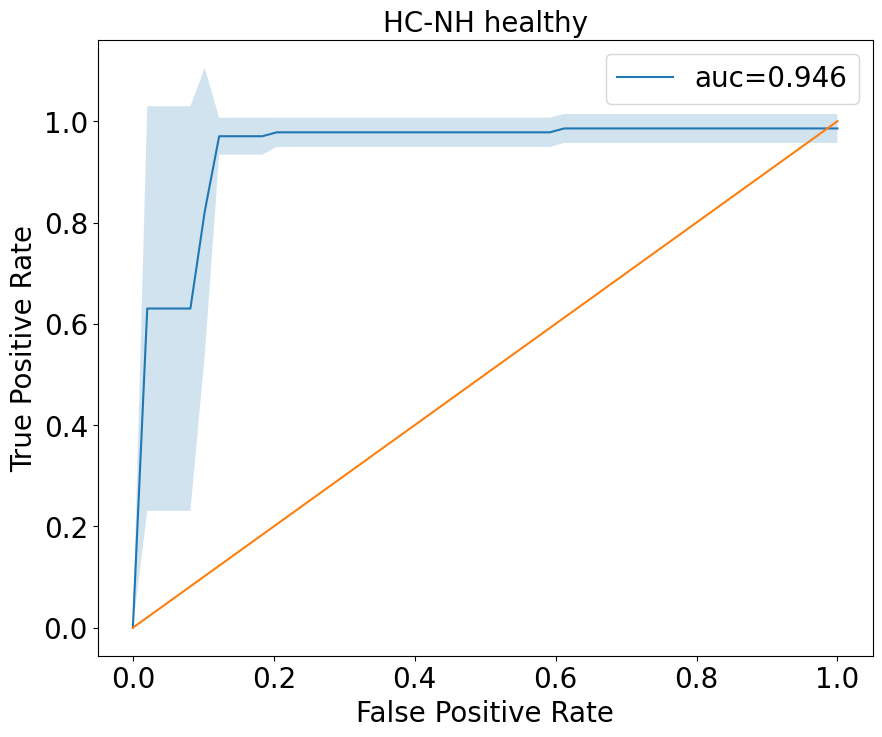

In [15]:
####Using RF method
#output=outputs_SVM
output=outputs_ANN
#output=outputs_RF

metricss=output[4]
print(metricss.head())
prediction_mat=output[0]
pred_labels_cond=output[1]
true_labels_condition=output[2]
condition_to_labels=output[3]
cf_matrix=confusion_matrix(pred_labels_cond,true_labels_condition)
print(cf_matrix)
print(cf_matrix[0,:]/np.sum(cf_matrix[0,:]))
for i in range(cf_matrix.shape[0]):
    cf_matrix[i,:]=cf_matrix[i,:]
print(cf_matrix)
plt.subplots(figsize=(10,8))
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
data_2 = pd.DataFrame(cf_matrix, list(condition_to_labels.keys()), list(condition_to_labels.keys()))
sns.heatmap(data_2.T, square=True, annot=True,cmap="YlGnBu", cbar = False,annot_kws={"size": 16},fmt='g')
score = accuracy_score(true_labels_condition, pred_labels_cond)
plt.xlabel('Predicted label\nAccuracy={:0.3f}'.format(score),fontsize=15)
plt.title('Condition heatmap',fontsize=20)
plt.savefig('confusion_matrix_cond_lendata_{}.jpg'.format(len(data)), bbox_inches = 'tight', pad_inches = 0.2,dpi=1000)

from sklearn import metrics

from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))




from scipy.interpolate import interp1d

class_of_interest=1
n_of_folds=5
columns_of_interest=[]
columns_of_interest_y=[]
for fold in range(n_of_folds):
    columns_of_interest.append('y_score_class_{}_fold_{}'.format(class_of_interest,fold))
    columns_of_interest_y.append('y_test_fold_{}'.format(fold))


fprs=[]
tprs=[]
roc_aucs=[]

fprs_len=[]

for n in range(len(columns_of_interest)):
    Y_score=prediction_mat[columns_of_interest[n]].values
    Y_test=prediction_mat[columns_of_interest_y[n]].values
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_score)
    fprs_len.append(len(fpr))
    fprs.append(fpr)

fprs_len=np.array(fprs_len)
mean_fpr=fprs[np.argmax(fprs_len)]

mean_fpr = np.linspace(0, 1, 50)

for n in range(len(columns_of_interest)):
    Y_score=prediction_mat[columns_of_interest[n]].values
    Y_test=prediction_mat[columns_of_interest_y[n]].values
    fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_score)
    print(tpr)
    print(fpr)
    roc_auc=metrics.auc(fpr, tpr)
    tp_d = interp1d(fpr, tpr, kind='nearest')
    tpr =  tp_d(mean_fpr)
    tprs.append(tpr)
    roc_aucs.append(roc_auc)

fpr=mean_fpr.copy()
tpr=np.mean(np.array(tprs),axis=0)
tpr_lower=np.mean(np.array(tprs),axis=0)-np.std(np.array(tprs),axis=0)
tpr_upper=np.mean(np.array(tprs),axis=0)+np.std(np.array(tprs),axis=0)
roc_aucs=np.array(roc_aucs)


plt.figure(figsize=(10, 8))
plt.plot(fpr,tpr,label='auc={:.3f}'.format(roc_aucs.mean()))
plt.fill_between(fpr,tpr_lower,tpr_upper,alpha=0.2)
y_d=np.linspace(0,1,10)
plt.plot(y_d,y_d)
plt.legend(fontsize=20)
plt.title('HC-NH healthy',fontsize=20)
plt.xlabel("False Positive Rate",fontsize=20)
plt.ylabel("True Positive Rate",fontsize=20)